In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x_t = np.linspace(0,200,1000)
b = np.random.uniform(-.05,.05,10)
y_t = 0.5
for i in range(1,10):
    omega = i*np.pi/20.
    y_t -= (0.318/i)*np.sin(omega*x_t) + b[i]*np.cos(omega*x_t)

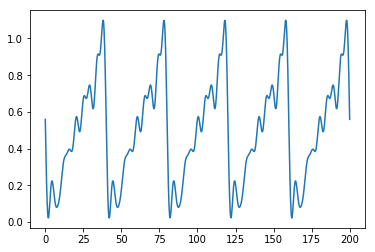

In [3]:
plt.plot(x_t,y_t)

In [4]:
SEQ = 600
HIDDEN = 300
INP_SIZE=1
LAYERS=1

In [5]:
def generator():
    
    x = np.linspace(0,200,1000)
    b = np.random.uniform(-.05,.05,10)
    y = 0.5
    for i in range(1,10):
        omega = i*np.pi/20.
        y -= (0.318/i)*np.sin(omega*x) + b[i]*np.cos(omega*x)
        
    for i in range(2000):
        idx = np.random.randint(0,400) #scalar
        #yield (x[idx:idx+SEQ],y[idx:idx+SEQ])        
        yield (x[idx:idx+SEQ],np.sin((1/10.)*x[idx:idx+SEQ]))

In [6]:
dataset = tf.data.Dataset.from_generator(generator,(tf.float32,tf.float32),((SEQ,),(SEQ,)))
dataset = dataset.repeat(1)
dataset = dataset.batch(1)
iterator = dataset.make_one_shot_iterator()
idx,y = iterator.get_next()
y.shape

TensorShape([Dimension(None), Dimension(600)])

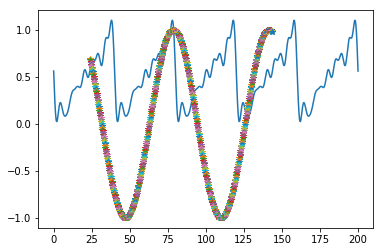

In [7]:
with tf.Session() as sess:
    x_,y_ = sess.run([idx,y])
    plt.plot(x_t,y_t)
    plt.plot(x_,y_,'*')

In [8]:
X = y[:,:-1]
target = y[:,1:]
X,target

(<tf.Tensor 'strided_slice:0' shape=(?, 599) dtype=float32>,
 <tf.Tensor 'strided_slice_1:0' shape=(?, 599) dtype=float32>)

In [9]:
def RNNCell(x:'Input Tensor [batch,1]',h:'Hidden state tensor [batch,hidden size]') -> '(batch,hidden)': 
    inp_size = x.shape[1]
    hidden_size = h.shape[1]
    
    with tf.variable_scope('params',reuse=tf.AUTO_REUSE):
        Whh = tf.get_variable("Whh",shape=(hidden_size,hidden_size),dtype=tf.float32,initializer=tf.initializers.orthogonal())
        Whx = tf.get_variable("Whx",shape=(inp_size,hidden_size),dtype=tf.float32,initializer=tf.initializers.glorot_uniform())
        b = tf.get_variable("b",shape=(hidden_size,),dtype=tf.float32,initializer=tf.initializers.zeros())
        
        h_next = tf.nn.relu(tf.add(tf.add(tf.matmul(h,Whh),tf.matmul(x,Whx)),b))
        #output = tf.layers.dense(h_next,1)
        
    #return (output,h_next)
    return h_next

In [10]:
def MultiLayerRNN(x:'(batch,1)',h:'[(batch,hidden_size), ...,(batch,hidden_size)]',num_layers) -> '[(b,h),..(b,h)]':
    h_prev = x
    h_next = []
    for l in range(num_layers):
        with tf.variable_scope("RNN" + str(l),reuse=tf.AUTO_REUSE):
            h_next.append(RNNCell(h_prev,h[l]))
        h_prev = h_next[l]
    return h_next      

In [11]:
def unroll_with_inputs(X:'(batch,seq_length)',h_initial:'(batch,HIDDEN)',seq_length:int):
    l = []
    #o = []
    h = h_initial
    for i in range(seq_length):
        x = tf.reshape(X[:,i],(tf.shape(X)[0],1)) #(Batch,1)
        #output,h_next = RNNCell(x,h)
        h_next = MultiLayerRNN(x,h,LAYERS)
        h = h_next
        l.append(h[-1])
        #o.append(output)
    H = tf.convert_to_tensor(l)
    #outputs = tf.convert_to_tensor(o)
    #outputs = tf.transpose(outputs,(1,0,2))
    #outputs = tf.reshape(outputs,(-1,seq_length))
    

    with tf.variable_scope("Out",reuse=tf.AUTO_REUSE):
        outputs = tf.layers.dense(H,1)
        outputs = tf.transpose(outputs,(1,0,2))
        outputs = tf.reshape(outputs,(-1,seq_length))
    
    return (outputs,H,h_next)   

In [12]:
def unroll_generate(x_initial:'(batch,1)',h_initial:'[(batch,HIDDEN),..,]',seq_length:int):
    x = x_initial
    h = h_initial
    W_d = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='Out/dense/kernel:0')[0]
    b_d = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='Out/dense/bias:0')[0] 
    eval_out = []
    for i in range(seq_length):
        h_next = MultiLayerRNN(x,h,LAYERS)
        x = tf.add(tf.matmul(h_next[-1],W_d),b_d)
        eval_out.append(x)
        h = h_next
        
    return eval_out

In [13]:
h_init = []
for l in range(LAYERS):
    h_init.append(tf.zeros((tf.shape(X)[0],HIDDEN)))
    
outputs,H,_ = unroll_with_inputs(X,h_init,SEQ-1)
outputs

<tf.Tensor 'Out/Reshape:0' shape=(?, 599) dtype=float32>

In [14]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'RNN0/params/Whh:0' shape=(300, 300) dtype=float32_ref>,
 <tf.Variable 'RNN0/params/Whx:0' shape=(1, 300) dtype=float32_ref>,
 <tf.Variable 'RNN0/params/b:0' shape=(300,) dtype=float32_ref>,
 <tf.Variable 'Out/dense/kernel:0' shape=(300, 1) dtype=float32_ref>,
 <tf.Variable 'Out/dense/bias:0' shape=(1,) dtype=float32_ref>]

In [15]:
loss = tf.reduce_mean(tf.square(outputs-target))
optimizer = tf.train.AdamOptimizer(0.0001)
train = optimizer.minimize(loss)

In [23]:
saver = tf.train.Saver()

In [9]:
!rm models/RNN2/*

In [10]:
def train_rnn():
    import time
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        start = time.time()
        try:
            i = 1
            tmp = []
            while True:
                i = i+1
                l,_ = sess.run([loss,train])
                tmp.append(l)
                if i%500 == 0:
                    avg_loss = np.array(tmp).mean()
                    print("Batch: ",i,avg_loss)
                    tmp = []

        except tf.errors.OutOfRangeError:
            pass
        
        end = time.time()
        elapsed = end-start
        print("Elapsed time : ", elapsed, " s")
        saver.save(sess,'models/RNN2/my_first_model.ckpt')

In [19]:
train_rnn()

Batch:  500 0.005349999
Batch:  1000 0.0001575209
Batch:  1500 7.2242874e-05
Batch:  2000 3.0236864e-05
Elapsed time :  96.01005911827087  s


In [207]:
# x_ii = tf.placeholder(tf.float32,(1,1),name="x_in")
# x_i = x_ii
# h_ii = tf.placeholder(tf.float32,(1,HIDDEN),name="h_")
# #h_ = h_ii
# h_ = tf.zeros((1,HIDDEN))
# eval_out = []
# for i in range(SEQ):
#     with tf.variable_scope("RNN"):
#         h_next = RNNCell(x_i,h_)
#     x_i = tf.add(tf.matmul(h_next,W_d),b_d)
#     eval_out.append(x_i)
#     h_ = h_next

In [20]:
X_eval = y[:,:300]
h_init = []
for l in range(LAYERS):
    h_init.append(tf.zeros((tf.shape(X)[0],HIDDEN)))
    
out_eval,_,h_last = unroll_with_inputs(X_eval,h_init,300)
#h_last = tf.zeros((1,HIDDEN))
x_last = tf.reshape(out_eval[:,-1],(-1,1))
eval_out = unroll_generate(x_last,h_last,300)

In [11]:
def val():
    with tf.Session() as sess:
        saver.restore(sess,'models/RNN2/my_first_model.ckpt')   
            
        try:
            while True:
                oe,eo,t = sess.run([out_eval,eval_out,target])
                                
                eo_array = np.array(eo).reshape(1,-1)
                predict = np.concatenate((oe,eo_array),axis=1).reshape(-1)

                plt.plot(t[0])
                plt.plot(predict,'*')
                break

        except tf.errors.OutOfRangeError:
            pass

INFO:tensorflow:Restoring parameters from models/RNN2/my_first_model.ckpt


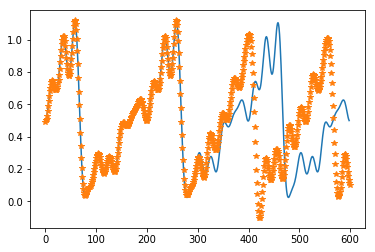

In [22]:
val()

### Keras API

**Overview**

In [20]:
#Create stacked cells
cellsX = [tf.keras.layers.SimpleRNNCell(32),tf.keras.layers.SimpleRNNCell(64,)]

In [22]:
#Create layer
layerX = tf.keras.layers.RNN(cellsX,return_state=True,return_sequences=True)

In [23]:
layerX

In [25]:
xx = tf.constant(5.,shape=(1,5,1))

In [26]:
yy = layerX(xx,initial_state=[tf.zeros((1,32)),tf.zeros((1,64))])

In [28]:
yy

[<tf.Tensor 'rnn_3/transpose_1:0' shape=(1, 5, 64) dtype=float32>,
 <tf.Tensor 'rnn_3/while/Exit_3:0' shape=(1, 32) dtype=float32>,
 <tf.Tensor 'rnn_3/while/Exit_4:0' shape=(1, 64) dtype=float32>]

### Create Keras Cells and stack them

In [11]:
X_in = tf.expand_dims(X,axis=2)
X_in

<tf.Tensor 'ExpandDims:0' shape=(?, 599, 1) dtype=float32>

In [12]:
cells = [tf.keras.layers.SimpleRNNCell(HIDDEN),tf.keras.layers.SimpleRNNCell(HIDDEN)]
rnn_layer = tf.keras.layers.RNN(cells,return_state=True,return_sequences=True,unroll=True)
with tf.variable_scope("RNN",reuse=tf.AUTO_REUSE):
    H,h1_last,h2_last = rnn_layer(X_in)
H,h1_last,h2_last

(<tf.Tensor 'RNN/rnn/transpose_1:0' shape=(?, 599, 300) dtype=float32>,
 <tf.Tensor 'RNN/rnn/Tanh_1196:0' shape=(?, 300) dtype=float32>,
 <tf.Tensor 'RNN/rnn/Tanh_1197:0' shape=(?, 300) dtype=float32>)

In [13]:
with tf.variable_scope("Out",reuse=tf.AUTO_REUSE):
    outputs = tf.layers.dense(H,1)
outputs = tf.reshape(outputs,(-1,599))
outputs,target

(<tf.Tensor 'Reshape:0' shape=(?, 599) dtype=float32>,
 <tf.Tensor 'strided_slice_1:0' shape=(?, 599) dtype=float32>)

In [14]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'RNN/rnn/kernel:0' shape=(1, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/recurrent_kernel:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/bias:0' shape=(300,) dtype=float32>,
 <tf.Variable 'RNN/rnn/kernel_1:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/recurrent_kernel_1:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/bias_1:0' shape=(300,) dtype=float32>,
 <tf.Variable 'Out/dense/kernel:0' shape=(300, 1) dtype=float32_ref>,
 <tf.Variable 'Out/dense/bias:0' shape=(1,) dtype=float32_ref>]

In [15]:
loss = tf.reduce_mean(tf.square(outputs-target))
optimizer = tf.train.AdamOptimizer(0.0001)
train = optimizer.minimize(loss)
saver = tf.train.Saver()

In [16]:
train_rnn()

Batch:  500 0.004218374
Batch:  1000 0.00013930404
Batch:  1500 3.6619498e-05
Batch:  2000 2.8299832e-05
Elapsed time :  185.27220153808594  s


In [17]:
X_eval = tf.expand_dims(y[:,:300],axis=2)
with tf.variable_scope("RNN",reuse=True):
    H_eval,h1_last,h2_last = rnn_layer(X_eval)
with tf.variable_scope("Out",reuse=True):
    out_eval = tf.layers.dense(H_eval,1)
H_eval,out_eval

(<tf.Tensor 'RNN_1/rnn/transpose_1:0' shape=(?, 300, 300) dtype=float32>,
 <tf.Tensor 'Out_1/dense/BiasAdd:0' shape=(?, 300, 1) dtype=float32>)

In [18]:
x_last = out_eval[:,-1]
x_last = tf.expand_dims(x_last,axis=2)
x_last,h1_last,h2_last

(<tf.Tensor 'ExpandDims_2:0' shape=(?, 1, 1) dtype=float32>,
 <tf.Tensor 'RNN_1/rnn/Tanh_598:0' shape=(?, 300) dtype=float32>,
 <tf.Tensor 'RNN_1/rnn/Tanh_599:0' shape=(?, 300) dtype=float32>)

INFO:tensorflow:Restoring parameters from models/RNN2/my_first_model.ckpt


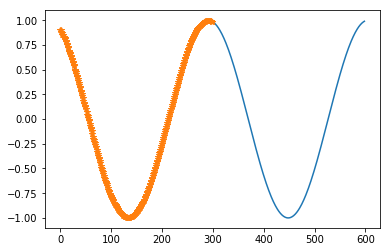

In [21]:
with tf.Session() as sess:
    saver.restore(sess,'models/RNN2/my_first_model.ckpt')   

    try:
        while True:
            oe,t = sess.run([out_eval,target])

            #eo_array = np.array(eo).reshape(1,-1)
            #predict = np.concatenate((oe,eo_array),axis=1).reshape(-1)

            plt.plot(t[0])
            plt.plot(oe[0],'*')
            break

    except tf.errors.OutOfRangeError:
        pass

In [19]:
eval_out = []
h1_l = h1_last
h2_l = h2_last
x_l = x_last
for i in range(300):
    with tf.variable_scope("RNN",reuse=True):
        rnn_layer.unroll = False
        H_predict,h1_l,h2_l = rnn_layer(x_l,initial_state=[h1_l,h2_l])
    with tf.variable_scope("Out",reuse=True):
        x_l = tf.layers.dense(H_predict,1)
        eval_out.append(x_l)

INFO:tensorflow:Restoring parameters from models/RNN2/my_first_model.ckpt


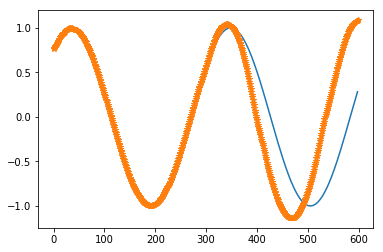

In [20]:
with tf.Session() as sess:
    saver.restore(sess,'models/RNN2/my_first_model.ckpt')   

    try:
        while True:
            oe,eo,t = sess.run([out_eval,eval_out,target])

            oe = oe.reshape(1,-1)
            eo_array = np.array(eo).reshape(1,-1)
            predict = np.concatenate((oe,eo_array),axis=1).reshape(-1)

            plt.plot(t[0])
            plt.plot(predict,'*')
            break

    except tf.errors.OutOfRangeError:
        pass

**Ensure new variables are not created**

In [22]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'RNN/rnn/kernel:0' shape=(1, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/recurrent_kernel:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/bias:0' shape=(300,) dtype=float32>,
 <tf.Variable 'RNN/rnn/kernel_1:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/recurrent_kernel_1:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/bias_1:0' shape=(300,) dtype=float32>,
 <tf.Variable 'Out/dense/kernel:0' shape=(300, 1) dtype=float32_ref>,
 <tf.Variable 'Out/dense/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'RNN/rnn/kernel/Adam:0' shape=(1, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/kernel/Adam_1:0' shape=(1, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/recurrent_kernel/Adam:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/recurrent_kernel/Adam_1:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/bias/Adam:0' 

## Summary

>1) Placeholders should be global. Do not create any graphs inside session

>2) Notice the way to reuse variables without having to get from collections (keras api)

>3) set unroll=false(in keras RNN object) when time size is equal to 1(during prediction)

>4) USe dataset api to create more neat code

>5) Set **reuse** = **True** (not AUTO_REUSE) in variable scope, when you want to reuse variables for sure 